<a href="https://colab.research.google.com/github/Mittra19/Image_Restoration/blob/main/Image_Restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import view_as_windows as viewW
from sklearn import preprocessing
from sklearn.linear_model import OrthogonalMatchingPursuit as omp
from scipy import sparse as sps
import scipy
from scipy.interpolate import griddata

In [ ]:
image = plt.imread("/content/drive/MyDrive/Colab Notebooks/kSVD/img01.png")
print(len(image.shape))

3


In [ ]:
image2 = plt.imread("/content/drive/MyDrive/Colab Notebooks/kSVD/barbara.png")
image2.shape

(512, 512)

In [ ]:
# Forming new image
bb = 8
overlap = 3
NN = int(np.ceil((image.shape[0]-bb)/overlap))*overlap+bb
MM = int(np.ceil((image.shape[1]-bb)/overlap))*overlap+bb
img_new = np.zeros((NN, MM, dims))
img_new[:h, :w, :] = image[:, :, :]
if dims == 3:
  print(img_new.shape)
  plt.imshow(img_new)
else:
  print(img_new.shape)
  plt.imshow(np.reshape(img_new, (img_new.shape[0], img_new.shape[1])), cmap = 'gray')

In [ ]:
plt.imshow(img_new)

In [ ]:
plt.imshow((image[:, :, 0] == 0), cmap = 'gray')

In [ ]:
row = int((image.shape[0]-bb)/overlap)
col = int((image.shape[1]-bb)/overlap)
dims = image.shape[2]
patches = []
for i in range(row):
  for j in range(col):
    patches.append(np.reshape(image[0+i*overlap:bb+i*overlap, 0+j*overlap:bb+j*overlap], (bb*bb*dims, 1)))

In [ ]:
patches = np.array(patches)
patches = patches.reshape(patches.shape[0], patches.shape[1])
patches.shape

In [ ]:
row = int((image.shape[0]-bb)/overlap)
col = int((image.shape[1]-bb)/overlap)
dims = image.shape[2]
I = np.zeros((image.shape[0], image.shape[1], dims))
counter = 0
for i in range(row):
  for j in range(col):
    I[0+i*overlap:bb+i*overlap, 0+j*overlap:bb+j*overlap] = np.reshape(patches[counter, :], (bb, bb, dims))
    counter = counter + 1

plt.imshow(I)

In [ ]:
def OMP(D, X, L):
  """
  Orthogonal Matching pursuit
  ---------------------------
  Inputs:
    D - Dictionary
    X - The signals to represent
    errorGoal - Maximum allowed representation error

  Output:
    A - Sparse Coefficient Matrix

  """
  n, P = X.shape
  n, K = D.shape
  temp = np.zeros((K, P))
  for i in range(P):
    a = []
    x=X[:, i]
    residual=x
    indx = []
    for j in range(L):
      proj= np.matmul(D.T,residual)
      pos = np.argmax(np.abs(proj), axis=0)
      indx.append(pos)
      a = np.matmul(scipy.linalg.pinv2(D[:, indx]),x)
      residual = x - np.matmul(D[: , indx],a)
      if np.sum(np.power(residual, 2)) <1e-6:
        break
    temp[indx, i] = a
    #A = sps.csr_matrix(temp)
  return temp

In [ ]:
phi = np.array(
    [
     [1, 0, 1, 0, 0, 1],
     [0, 1, 1, 1, 0, 0],
     [1, 0, 0, 1, 1, 0],
     [0, 1, 0, 0, 1, 1]
    ]
, dtype='float64')

y = np.array(
    [
     [1, 2],
     [2, 5],
     [3, 6],
     [5, 8]
    ]
)

msk = np.array(
    [
     [0, 0],
     [0, 1],
     [1, 1],
     [1, 0]
    ]
)
print("Data(y) shape: "+str(y.shape))
print("phi shape: "+str(phi.shape))

Data(y) shape: (4, 2)
phi shape: (4, 6)


In [34]:
def OMP_Inpainting(D, X, Mask, sigma, rc_min, n_nonzero_coeff):
  """
  Orthogonal Matching pursuit
  ---------------------------
  Inputs:
    D - Dictionary
    X - The signals to represent
    errorGoal - Maximum allowed representation error

  Output:
    A - Sparse Coefficient Matrix

  """
  n, P = X.shape
  n, K = D.shape
  temp = np.zeros((K, P))
  print("Data shape: "+str(X.shape))
  print("Dict shape: "+str(D.shape))
  for i in range(P):
    Mpos = np.argwhere(Mask[:, i]==0)
    #print("Mpos shape:"+str(Mpos.shape))
    Mpos = Mpos.reshape(1, Mpos.shape[0])[0]
    print("Mpos:"+str(Mpos))
    Dict = D[Mpos, :]
    #print(Dict.shape)
    #print(np.dot(Dict.T, Dict))
    #print(np.diag(np.dot(Dict.T, Dict)))
    div = np.sqrt(np.diag(np.dot(Dict.T, Dict)))
    div[np.argwhere(div == 0)] = 0.000000001
    #print(div)
    #div = np.nan_to_num(div)
    W=1.0/div;
    #print("W: "+str(W))
    Dict=np.dot(Dict, np.diag(W));
    x=X[Mpos,i] # patch exclude mask
    ##print(x)
    x = x.reshape(x.shape[0], -1)
    a = []
    DD = []
    residual=x
    indx = []
    j = 0
    rc_max = 99999
    threshold = np.linalg.norm(x)*sigma
    #print(len(a))
    print("residual: "+str(residual))
    while np.linalg.norm(residual)>threshold and rc_max>rc_min and len(a)<n_nonzero_coeff:
      
      proj= np.matmul(Dict.T,residual)
      pos = np.argmax(np.abs(proj), axis=0)
      indx.append(pos)
      if j==0:
        DD.append(Dict[:, pos])
        DDD = np.array(DD)
        DDD = DDD.reshape(DDD.shape[0]*DDD.shape[1], DDD.shape[2])
      else:
        DDD = np.concatenate((DDD, Dict[:, pos]), axis=1)
      ##print("DDD shape: "+str(DDD.shape))
      
      #print("DDD shape: "+str(DDD.shape))
      #print("x shape: and type: "+str(x.shape)+", "+str(type(x)))
      a = np.matmul(scipy.linalg.pinv2(DDD),x)
      #print("a shape: and type: "+str(a.shape)+", "+str(type(a)))
      residual = x - np.matmul(DDD,a)
      j = j+1
    print("a: "+str(a))
    temp[indx, i] = a
    temp[:, i] = np.multiply(W, temp[:, i])
    #A = sps.csr_matrix(temp)
  return temp

In [ ]:
blkMask[0, :]

array([False, False,  True,  True, False,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
        True,  True,  True,  True, False,  True, False,  True,  True,
       False])

In [33]:
Coeff = OMP_Inpainting(DCT, blkMatrix.T, blkMask.T, sigma, rc_min, max_coeff)
#Coeff = omp(n_nonzero_coefs= max_coeff, fit_intercept=False).fit(DCT, np.multiply(blkMatrix, blkMask).T).coef_.T

Data shape: (64, 61235)
Dict shape: (64, 256)
Mpos:[ 0  1  4  7  8 18 19 21 26 37 38 39 49 50 53 58 60 63]
residual: [[0.67058825]
 [0.67843139]
 [1.        ]
 [1.        ]
 [0.60392159]
 [0.70588237]
 [0.78823531]
 [0.80392158]
 [0.70980394]
 [0.88235295]
 [0.9254902 ]
 [0.93333334]
 [0.92156863]
 [0.96862745]
 [0.9254902 ]
 [0.68235296]
 [0.8509804 ]
 [0.81568629]]
a: [[ 3.5917521 ]
 [-0.35091644]
 [ 0.24145815]
 [-0.27289905]
 [-0.16490851]
 [ 0.11598547]
 [-0.14949605]
 [ 0.07925963]
 [ 0.06504333]
 [ 0.03070311]]
Mpos:[ 1  4  7 15 16 18 22 29 30 34 35 36 37 46 50 54 55 57 60]
residual: [[1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.78823531]
 [0.80392158]
 [0.8392157 ]
 [0.8392157 ]
 [0.83137256]
 [0.88235295]
 [0.9254902 ]
 [0.93333334]
 [0.95294118]
 [0.92156863]
 [0.9254902 ]
 [0.96862745]
 [0.92156863]
 [0.8509804 ]
 [0.81568629]]
a: [[ 3.92978461]
 [ 0.24162491]
 [-0.09176307]
 [ 0.10386344]
 [-0.07535941]
 [-0.07595894]
 [-0.04393792]
 [-0.04436293]
 [ 0.0159051

In [ ]:
A = OMP_Inpainting(D=phi, X=y, Mask=msk, sigma=0.01, rc_min=0.01, n_nonzero_coeff=2)

Data shape: (4, 2)
Dict shape: (4, 6)
residual: [[3]
 [5]]
a: [[4.24264069]
 [2.        ]]
residual: [[5]
 [6]]
a: [[7.07106781]
 [1.        ]]


In [ ]:
A

array([[0., 1.],
       [2., 0.],
       [0., 0.],
       [0., 5.],
       [3., 0.],
       [0., 0.]])

In [ ]:
B = OMP(phi, y, 2)
B

array([[0. , 0. ],
       [2. , 0. ],
       [0. , 3.5],
       [0. , 0. ],
       [3. , 7. ],
       [0. , 0. ]])

In [ ]:
from scipy.spatial import Delaunay

In [ ]:
pos = np.argwhere(c == 0)
N, M = img_n.shape
im_r = img_n[pos]


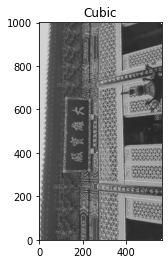

In [ ]:
from scipy.interpolate import griddata
pos = np.argwhere(mask == 0)
N, M = image[:, :, 0].shape
img = image[:, :, 0]
grid_x, grid_y = np.mgrid[0:N, 0:M]
grid_z2 = griddata(pos, np.array(img[pos[:, 0], pos[:, 1]]), (grid_x, grid_y), method='cubic')
plt.imshow(grid_z2.T, extent=(0,N,0,M), origin='lower', cmap='gray')
plt.title('Cubic')
plt.show()

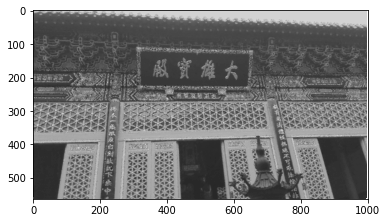

In [ ]:
plt.imshow(grid_z2, cmap='gray')

In [ ]:
np.array(img[pos[:, 0], pos[:, 1]])[0]

0.6705882549285889

In [ ]:
Interpolation(image[:, :, 0], mask, dims)

[[  0   0]
 [  0   1]
 [  0   4]
 ...
 [562 985]
 [562 989]
 [562 996]]
(191420, 2)


#Main Functions

In [2]:
def image_read(image_path):
  image = plt.imread(image_path)
  if len(image.shape) == 3:
    print("Image shape: "+str(image.shape))
    plt.imshow(image)
  else:
    plt.imshow(image, cmap='gray')
    image = image.reshape(image.shape[0], image.shape[1], 1)
    print("Image shape: "+str(image.shape))
  return image, image.shape[0], image.shape[1], image.shape[2]

In [3]:
def form_compatible_image(bb, overlap, image):
  NN = int(np.ceil((image.shape[0]-bb)/overlap))*overlap+bb
  MM = int(np.ceil((image.shape[1]-bb)/overlap))*overlap+bb
  img_new = np.zeros((NN, MM, dims))
  img_new[:h, :w, :] = image[:, :, :]
  if dims == 3:
    print(img_new.shape)
    plt.imshow(img_new)
  else:
    print(img_new.shape)
    plt.imshow(np.reshape(img_new, (img_new.shape[0], img_new.shape[1])), cmap = 'gray')
  return img_new

In [26]:
def get_mask(image):
  mask = (image[:, :, 0] == 0)
  plt.imshow(mask, cmap='gray')
  return mask

In [5]:
def extract_image_patches(image, bb, overlap):
  row = int((image.shape[0]-bb)/overlap)
  col = int((image.shape[1]-bb)/overlap)
  dims = image.shape[2]
  patches = []
  for i in range(row):
    for j in range(col):
      patches.append(np.reshape(image[0+i*overlap:bb+i*overlap, 0+j*overlap:bb+j*overlap], (bb*bb*dims, 1)))

  patches = np.array(patches)
  patches = patches.reshape(patches.shape[0], patches.shape[1])
  return patches

In [6]:
#edit needed
def extract_image_from_patches(patches, bb, overlap, image):
  row = int((image.shape[0]-bb)/overlap)
  col = int((image.shape[1]-bb)/overlap)
  #print("Patches shape: "+str(patches.shape))
  #print("row: "+str(row))
  #print("col: "+str(col))
  dims = image.shape[2]
  I = np.zeros((image.shape[0], image.shape[1], dims))
  counter = 0
  for i in range(row):
    for j in range(col):
      #print("0+i*overlap:bb+i*overlap, 0+j*overlap:bb+j*overlap"+str(0+i*overlap)+":"+str(bb+i*overlap)+", "+str(0+j*overlap)+":"+str(bb+j*overlap)+" counter: "+str(counter))
      I[0+i*overlap:bb+i*overlap, 0+j*overlap:bb+j*overlap] = np.reshape(patches[counter , :], (bb, bb, dims))
      counter = counter + 1
  #plt.imshow(I)
  #print(I.shape)
  return I

In [7]:
def Interpolation(img, mask, dims):
  pos = np.argwhere(mask == 0)
  N, M = img.shape
  img_r = img
  grid_x, grid_y = np.mgrid[0:N, 0:M]
  grid_z2 = griddata(pos, np.array(img_r[pos[:, 0], pos[:, 1]]), (grid_x, grid_y), method='cubic')
  #plt.imshow(grid_z2, origin='lower', cmap='gray')
  nan_pos = np.argwhere(np.isnan(grid_z2) == 1)
  grid_z2[nan_pos[:, 0], nan_pos[:, 1]] = 0.5
  #print(np.min(grid_z2))
  #plt.title('Cubic')
  #plt.show()
  return grid_z2

In [41]:
def average_cardinality(gamma):
  count = 0
  for i in range(gamma.shape[1]):
    for j in range(gamma.shape[0]):
      if gamma[j, i] != 0:
        count = count + 1

  print(count/gamma.shape[1])

In [43]:
def OMP_Inpainting(D, X, Mask, sigma, rc_min, n_nonzero_coeff):
  """
  Orthogonal Matching pursuit
  ---------------------------
  Inputs:
    D - Dictionary
    X - The signals to represent
    errorGoal - Maximum allowed representation error

  Output:
    A - Sparse Coefficient Matrix

  """
  n, P = X.shape
  n, K = D.shape
  temp = np.zeros((K, P))
  print("Data shape: "+str(X.shape))
  print("Dict shape: "+str(D.shape))
  for i in range(P):
    Mpos = np.argwhere(Mask[:, i]==0)
    Mpos = Mpos.reshape(1, Mpos.shape[0])[0]
    Dict = D[Mpos, :]
    div = np.sqrt(np.diag(np.dot(Dict.T, Dict)))
    div[np.argwhere(div == 0)] = 0.000000001
    W=1.0/div;
    Dict=np.dot(Dict, np.diag(W));
    x=X[Mpos,i] # patch exclude mask
    x = x.reshape(x.shape[0], -1)
    a = []
    DD = []
    residual=x
    indx = []
    j = 0
    rc_max = 99999
    threshold = np.linalg.norm(x)*sigma

    while np.linalg.norm(residual)>threshold and rc_max>rc_min and len(a)<n_nonzero_coeff:
      
      proj= np.matmul(Dict.T,residual)
      pos = np.argmax(np.abs(proj), axis=0)
      indx.append(pos)
      if j==0:
        DD.append(Dict[:, pos])
        DDD = np.array(DD)
        DDD = DDD.reshape(DDD.shape[0]*DDD.shape[1], DDD.shape[2])
      else:
        DDD = np.concatenate((DDD, Dict[:, pos]), axis=1)
      
      a = np.matmul(scipy.linalg.pinv2(DDD),x)
      
      residual = x - np.matmul(DDD,a)
      j = j+1
   
    temp[indx, i] = a
    temp[:, i] = np.multiply(W, temp[:, i])
    
  return temp

Image shape: (563, 1000, 3)


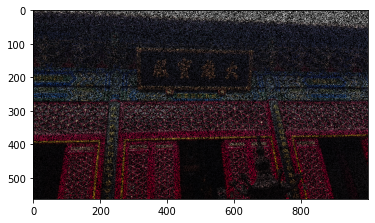

In [8]:
image, h, w, dims = image_read("/content/drive/MyDrive/Colab Notebooks/kSVD/Test_Fig2_Missing.png")

(563, 1001, 3)


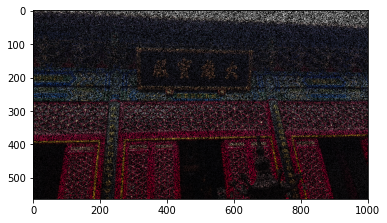

In [9]:
image = form_compatible_image(bb=8, overlap=3, image=image)

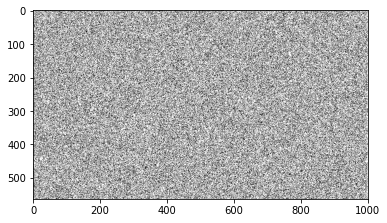

In [27]:
mask = get_mask(image)

In [28]:
patches = extract_image_patches(image=image, bb=8, overlap=3)

In [29]:
I = extract_image_from_patches(patches=patches, bb=8, overlap=3, image=image)

##Interpolation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


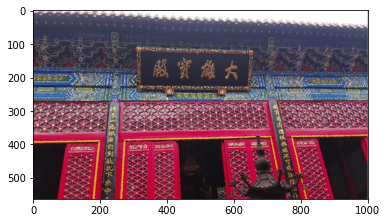

In [30]:
out = np.zeros((image.shape[0], image.shape[1], dims))
for i in range(dims):
  IMin0 = image[:, :, i]
  out[:, :, i] = Interpolation(IMin0, mask, dims)
plt.imshow(out)

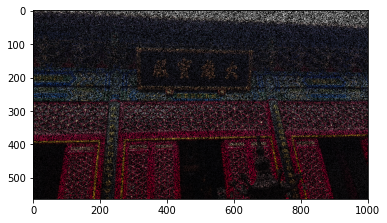

In [31]:
plt.imshow(image)

##Orthogonal Matching Pursuit

In [35]:
K =  256 #No of atoms in the dictionary
bb = 8 #block size
blkMask = extract_image_patches(image=mask.reshape(mask.shape[0], mask.shape[1], 1), bb=8, overlap=3)
img_inpaint = np.zeros((image.shape))
img_inpaint[:, :, 1] = Interpolation(image[:, :, 1], mask, dims)
img_inpaint[:, :, 2] = Interpolation(image[:, :, 2], mask, dims)

IMin0 = image[:, :, 0]
DCT = np.zeros((bb, int(np.sqrt(K))))
for k in range(int(np.sqrt(K))-1):
  V = np.cos(np.linspace(0,bb-1, bb).T*k*np.pi/int(np.sqrt(K)))
  if k>0:
    V=V-np.mean(V)
  DCT[:, k+1] = V/np.linalg.norm(V)
DCT = np.kron(DCT, DCT)

blkMatrix = extract_image_patches(image=IMin0.reshape(IMin0.shape[0], IMin0.shape[1], 1), bb=8, overlap=3)
sigma = 0.001; 
rc_min = 0.01;
max_coeff = 10;
#print("DCT shape: "+str(DCT.shape))

In [ ]:
Coeff = OMP_Inpainting(DCT, blkMatrix.T, blkMask.T, sigma, rc_min, max_coeff)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


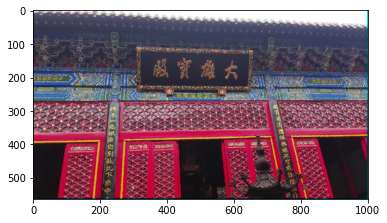

In [37]:
img_n = extract_image_from_patches(np.dot(DCT, Coeff).T, bb, 3, IMin0.reshape(IMin0.shape[0], IMin0.shape[1], 1))
img_n = img_n.reshape(img_n.shape[0], img_n.shape[1])
img_inpaint[:, :, 0] = img_n
img_out = img_inpaint[:image.shape[0], :image.shape[1], : ]
plt.imshow(img_out)

In [42]:
average_cardinality(Coeff)

9.739413733975667


In [40]:
Coeff[:, 0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  6.7726727 ,  0.        ,  0.        ,
       -0.67107597,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.29006494,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.45104269,  0.  